## functions

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

global ny, N, a1
ny = 10 # unit cell number in y direction
N = 2*ny
a1 = np.sqrt(3)/(2) # a = 1, a1 = a*sqrt(3)/2
    
def NB(T, E):
    # Bose distribution
    E = np.real(E)
    if abs(E/T) > 500:
        return 0
    else: return 1/(np.exp(E/T) - 1) 

def eigenv(H):
    '''  setup eigenvalues and eigenvectors
    parameters:
        H: np.ndarray
            Hamiltonian matrix
    returns:
        E: list
            eigenvalues
        U: np.ndarray
            eigenvectors
            U[i, m]: m: energy, i: sites
        U_dag: np.ndarray
            conjugate transpose of U
    '''
    
    E, U = np.linalg.eig(H)
    U_dag = np.conjugate(U).T
    
    return E, U, U_dag
    # return E

def hamiltonian_0(j, J, d, h, k):
    ''' H in A, B basis
    '''
    
    ni = lambda i: i % N
    
    A = []
    B = []
    for i in range(ny):
        A.append(i*2)
        B.append(i*2 + 1)
        
    K = k*a1
    
    mat = np.eye(N, dtype=np.complex64) * (3*j+6*J+h)
    
    for i in A:
        # NN
        mat[ni(i), ni(i+1)] -= 2*j*np.cos(K)
        mat[ni(i), ni(i-1)] -= j 
        # NNN
        mat[ni(i), ni(i+2)] -= 2*J*np.cos(K)
        mat[ni(i), ni(i-2)] -= 2*J*np.cos(K)
        mat[ni(i+2), ni(i)] -= 2*J*np.cos(K)
        mat[ni(i-2), ni(i)] -= 2*J*np.cos(K)
        mat[ni(i), ni(i)] -= 2*J*np.cos(2*K)
        # DMI
        mat[ni(i), ni(i+2)] += 2*d*np.sin(K)
        mat[ni(i), ni(i-2)] += 2*d*np.sin(K)
        mat[ni(i+2), ni(i)] += 2*d*np.sin(K)
        mat[ni(i-2), ni(i)] += 2*d*np.sin(K)
        mat[ni(i), ni(i)] -= 2*d*np.sin(2*K)
        
        
    for i in B: 
        # NN
        mat[ni(i), ni(i+1)] -= j
        mat[ni(i), ni(i-1)] -= 2*j*np.cos(K)
        # NNN
        mat[ni(i), ni(i+2)] -= 2*J*np.cos(K)
        mat[ni(i), ni(i-2)] -= 2*J*np.cos(K)
        mat[ni(i+2), ni(i)] -= 2*J*np.cos(K)
        mat[ni(i-2), ni(i)] -= 2*J*np.cos(K)
        mat[ni(i), ni(i)] -= 2*J*np.cos(2*K)
        # DMI
        mat[ni(i), ni(i+2)] -= 2*d*np.sin(K)
        mat[ni(i), ni(i-2)] -= 2*d*np.sin(K)
        mat[ni(i+2), ni(i)] -= 2*d*np.sin(K)
        mat[ni(i-2), ni(i)] -= 2*d*np.sin(K)
        mat[ni(i), ni(i)] += 2*d*np.sin(2*K)
        
    # boundary condition
    
    i = 0
    mat[ni(i), ni(i-1)] = 0
    mat[ni(i), ni(i-2)] = 0
    
    i = 1
    mat[ni(i), ni(i-2)] = 0
    
    i = N-2
    mat[ni(i), ni(i+2)] = 0
    
    i = N-1
    mat[ni(i), ni(i+1)] = 0
    mat[ni(i), ni(i+2)] = 0

    return mat/2

def hamiltonian_mft(iteration, T, jn, J, d, h, kx, txtout=None):
    ''' H in u, d basis
    '''
    
    K = kx*a1
    
    H_0 = hamiltonian_0(jn, J, d, h, kx)
    E, U, U_dag = eigenv(H_0) # 1st order eigenvalues and eigenvectors
    
    Ei = np.sort(E)
    if txtout is not None:
        with open(txtout, 'w') as f:
            for i in range(N):
                f.write(f'E{i},')
            f.write('\n')
            for i in range(N):
                f.write(f'{np.real(Ei[i])},')
            f.write('\n')
    
    H_1 = np.zeros((N, N), dtype=np.complex64)
    H_1 += U_dag @ H_0 @ U # 1st order H in u, d basis
    
    A = []
    B = []
    for i in range(ny):
        A.append(i*2)
        B.append(i*2 + 1)
        
    for iter in range(iteration):
        
        def V(m, n, i, j):
            if i < 0 or i >= N or j < 0 or j >= N:
                return 0 # OBC
            else: return U_dag[m, i] * U[j, n]  
        
        N_b = 0
        for i in range(N):
            N_b += NB(T, E[i]) / N
        print(f'Number of bosons per site: {N_b}')
        
        for m in range(N):
            for n in range(N):
                
                for a in A:
                    # NN terms
                    H_1[m, n] += (jn*N_b) * (V(m,n,a,a-1) + V(m,n,a-1,a) - V(m,n,a-1,a-1) - V(m,n,a,a))
                    H_1[m, n] += (jn*N_b) * (V(m,n,a,a+1) + V(m,n,a+1,a) - V(m,n,a+1,a+1) - V(m,n,a,a)) * 2*np.cos(K)
                    
                    # NNN terms
                    H_1[m, n] += (J*N_b) * (V(m,n,a,a-2)+V(m,n,a-2,a)-V(m,n,a-2,a-2)-V(m,n,a,a)) * 2*np.cos(K)
                    H_1[m, n] += (J*N_b) * (V(m,n,a,a+2)+V(m,n,a+2,a)-V(m,n,a+2,a+2)-V(m,n,a,a)) * 2*np.cos(K)
                    
                    # DMI terms
                    H_1[m, n] += (d*N_b) * (V(m,n,a,a-2)-V(m,n,a-2,a)+V(m,n,a,a+2)-V(m,n,a+2,a)) * 2*np.sin(K)
                    
                for b in B:
                    # NN terms
                    H_1[m, n] += (jn*N_b) * (V(m,n,b,b-1) + V(m,n,b-1,b) - V(m,n,b-1,b-1) - V(m,n,b,b)) * 2*np.cos(K)
                    H_1[m, n] += (jn*N_b) * (V(m,n,b,b+1) + V(m,n,b+1,b) - V(m,n,b+1,b+1) - V(m,n,b,b))
                    
                    # NNN terms
                    H_1[m, n] += (J*N_b) * (V(m,n,b,b-2)+V(m,n,b-2,b)-V(m,n,b-2,b-2)-V(m,n,b,b)) * 2*np.cos(K)
                    H_1[m, n] += (J*N_b) * (V(m,n,b,b+2)+V(m,n,b+2,b)-V(m,n,b+2,b+2)-V(m,n,b,b)) * 2*np.cos(K)
                    
                    # DMI terms
                    H_1[m, n] -= (d*N_b) * (V(m,n,b,b-2)-V(m,n,b-2,b)+V(m,n,b,b+2)-V(m,n,b+2,b)) * 2*np.sin(K)
        
        H_D = U @ H_1 @ U_dag # back to A, B basis
        E, U, U_dag = eigenv(H_D)
        H_1 = U_dag @ H_0 @ U # reset H_1 for next iteration
        print(f'det(UUdagger)={np.linalg.det(U@U_dag)}')
        
        Ei = np.sort(E)
        if txtout is not None:
            with open(txtout, 'a') as f:
                for i in range(N):
                    f.write(f'{np.real(Ei[i])},')
                f.write('\n')
    
        print(f'Iteration {iter} finished.')
        
        # with open(f'./H{T}{jn}{J}{d}.txt', 'a') as f:
        #     f.write(f'Iteration {iter} H matrix:\n')
        #     for i in range(N):
        #         for j in range(N):
        #             f.write('{0:.4f},'.format(np.real(H[i, j])))
        #         f.write('\n')
    
    return E

## 2nd order

### convergence

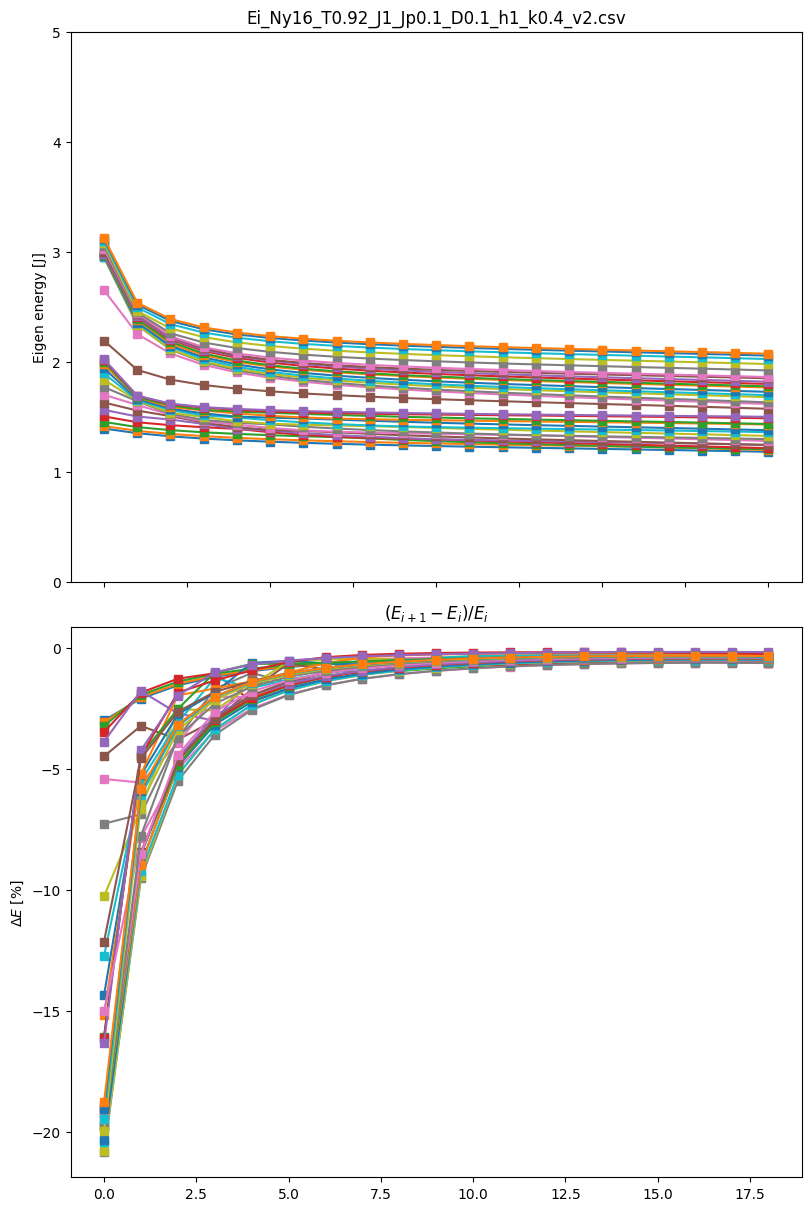

In [93]:
file = f'Ei_Ny{16}_T{0.92}_J{1}_Jp{0.1}_D{0.1}_h{1}_k{0.4}_v2.csv'
iterations = 20

fig, axs = plt.subplots(2, 1, figsize=(8, 12), layout='constrained')

data = pd.read_csv('./data/' + file)

ax = axs[0]
for i in range(len(data.columns)):
    ax.plot(data.iloc[:, i], label=f'E{i}', marker='s')
    
ax.set_ylim(0, 5)
ax.set_ylabel('Eigen energy [J]')
ax.label_outer()
ax.set_title(file)

ax = axs[1]
for i in range(len(data.columns)):
    delta = []
    for j in range(iterations-1):
        delta.append(100*(data.iloc[j+1, i]-data.iloc[j, i])/data.iloc[j, i])
    ax.plot(delta, label=f'E{i}', marker='s')

# ax.set_ylim(-200, 200)
ax.set_ylabel('$\Delta E$ [%]')
ax.set_title('$(E_{i+1} - E_i)/E_i$')

plt.savefig(f'./louvre/{file[:-4]}_v2.png', dpi=100)
plt.show()

In [92]:
j = 1
J = 0.1
D = 0.1
h = 1
T = 0.92

iter = 20

k = 0.4
K = k*np.pi/a1

file = f'./data/Ei_Ny{ny}_T{T}_J{j}_Jp{J}_D{D}_h{h}_k{k}_v2.csv'

hamiltonian_mft(iter, T, j, J, D, h, K, txtout=file)
# hamiltonian_mft(3, T, j, J, D, h, K)

Number of bosons per site: 0.11073703318834305
det(UUdagger)=(0.9999994039535522+0j)
Iteration 0 finished.
Number of bosons per site: 0.14888063073158264
det(UUdagger)=(1.0000001192092896+0j)
Iteration 1 finished.
Number of bosons per site: 0.16869738698005676
det(UUdagger)=(1.0000003576278687+0j)
Iteration 2 finished.
Number of bosons per site: 0.18104901909828186
det(UUdagger)=(0.9999997615814209+0j)
Iteration 3 finished.
Number of bosons per site: 0.18961688876152039
det(UUdagger)=(0.9999995827674866+0j)
Iteration 4 finished.
Number of bosons per site: 0.1960039585828781
det(UUdagger)=(0.9999992847442627+0j)
Iteration 5 finished.
Number of bosons per site: 0.2010229229927063
det(UUdagger)=(0.9999999403953552+0j)
Iteration 6 finished.
Number of bosons per site: 0.2051316499710083
det(UUdagger)=(1.0000007152557373+0j)
Iteration 7 finished.
Number of bosons per site: 0.20860877633094788
det(UUdagger)=(1+0j)
Iteration 8 finished.
Number of bosons per site: 0.21163472533226013
det(UUdagg

array([2.074287 +0.j, 2.0571017+0.j, 2.0258782+0.j, 1.9804623+0.j,
       1.9226246+0.j, 1.183287 +0.j, 1.1992533+0.j, 1.2164041+0.j,
       1.2072554+0.j, 1.2442292+0.j, 1.2461891+0.j, 1.2817259+0.j,
       1.3273554+0.j, 1.2984403+0.j, 1.3792753+0.j, 1.3617555+0.j,
       1.4313108+0.j, 1.4361585+0.j, 1.4876996+0.j, 1.5012745+0.j,
       1.5737998+0.j, 1.8622934+0.j, 1.8511649+0.j, 1.6173232+0.j,
       1.6324204+0.j, 1.8198186+0.j, 1.7995142+0.j, 1.6794938+0.j,
       1.7277261+0.j, 1.7677218+0.j, 1.7777995+0.j, 1.6979517+0.j],
      dtype=complex64)

### spectrum

In [118]:
j = 1
J = 0.1
D = 0.1
h = 1
T = 0.2

iter = 20

K = np.pi/a1
spec = np.array([0.1, 0.2, 0.3, 0.39, 0.42, 0.44, 0.46, 0.48, 0.52, 0.56, 0.6, 0.7, 0.8, 1.0])*K
# spec = np.linspace(0, K, 11)
# spec = np.linspace(0.4*K, 0.6*K, 11)
E_1 = []
E_2 = []
# bc = ['A', 'B'] # boundary condition
for k in spec:
    print(f'Calculating k={k/K:.3f}...')
    Ea = 0
    Eb = 0
    Ea, _, _ = eigenv(hamiltonian_0(j, J, D, h, k))
    E_1.append(np.real(Ea))
    Eb = hamiltonian_mft(iter, T, j, J, D, h, k)
    E_2.append(np.real(Eb))
    
E1 = np.array(E_1)
E2 = np.array(E_2)
bands = np.array([spec] * len(Ea))/K

Calculating k=0.100...
Number of bosons per site: 0.015802867710590363
det(UUdagger)=(1.0000004768371582+0j)
Iteration 0 finished.
Number of bosons per site: 0.016245456412434578
det(UUdagger)=(1.000000238418579+0j)
Iteration 1 finished.
Number of bosons per site: 0.016258375719189644
det(UUdagger)=(0.9999996423721313+0j)
Iteration 2 finished.
Number of bosons per site: 0.01625875011086464
det(UUdagger)=(1.000000238418579+0j)
Iteration 3 finished.
Number of bosons per site: 0.016258763149380684
det(UUdagger)=(0.9999989867210388+0j)
Iteration 4 finished.
Number of bosons per site: 0.016258761286735535
det(UUdagger)=(1.0000003576278687+0j)
Iteration 5 finished.
Number of bosons per site: 0.016258757561445236
det(UUdagger)=(0.9999998807907104+0j)
Iteration 6 finished.
Number of bosons per site: 0.016258757561445236
det(UUdagger)=(0.999998927116394+0j)
Iteration 7 finished.
Number of bosons per site: 0.01625875197350979
det(UUdagger)=(1+0j)
Iteration 8 finished.
Number of bosons per site: 

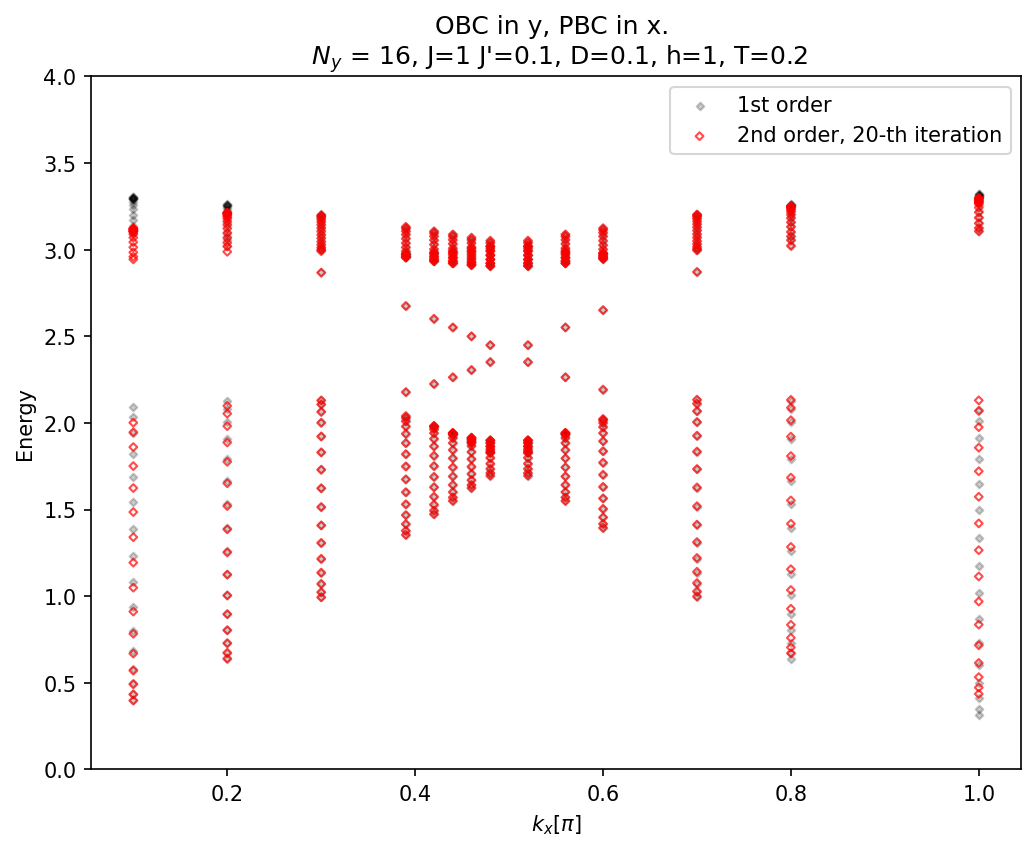

In [119]:
fig, ax = plt.subplots(figsize=(8,6), dpi=150)

for i in range(len(Ea)-1):
    ax.scatter(bands[i, :], E1[:,i], 
        color='k', s=7, alpha=0.2, marker='D')
    ax.scatter(bands[i, :], E2[:,i], 
        edgecolors='r', facecolors='none', s=7, alpha=0.7, marker='D', zorder=10)

ax.scatter(bands[N-1, :], E1[:,N-1], 
    color='k', s=7, alpha=0.2, marker='D', label='1st order', zorder=1)
ax.scatter(bands[N-1, :], E2[:,N-1], 
    edgecolors='r', facecolors='none', s=7, alpha=0.7, marker='D', label=f'2nd order, {iter}-th iteration', zorder=10)
    
ax.set_xlabel('$k_x [\\pi]$')
ax.set_ylabel('Energy')
# ax.set_xlim(0, 1)
# ax.set_xlim(0.5, 1.5)
ax.set_ylim(0, 4)
ax.legend()
title = f"OBC in y, PBC in x. \n $N_y$ = {ny}, J={j} J'={J}, D={D}, h={h}, T={T}"
ax.set_title(title)

plt.savefig(f'./louvre/MFT_{ny}_J{j}_Jp{J}_D{D}_h{h}_T{T}_itr{iter}.png', dpi=100)

plt.show()